<p style="font-family: Arial; font-size:3.2em;color:blue; font-style:bold"><br>
Прогнозирование оттока студентов
</p><br>

Финальное задание с онлайн курса по Машинному обучению с сайта https://stepik.org/course/4852/syllabus 
Требуется предсказать, сможет ли пользователь успешно закончить онлайн курс Анализ данных в R. Считается, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий.
В данных:<br>

* **submission_data.csv**
* **events_data.csv**
<br>
хранится информация о решениях и действиях для студентов  с июня 2015 по май 2018<br>

Используя данные о первых двух днях активности на курсе необходимо предсказать, наберет ли пользователь более **40 баллов** на курсе или нет.


In [1]:
#импортируем основные модули
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline


In [246]:
import seaborn as sns
import numpy as np

<p style="font-family: Arial; font-size:2.75em;color:#2462C0; font-style:bold"><br>
Обработка данных
</p>


In [30]:
#смотрим на данные по событиям (events_data.csv)
events = pd.read_csv('event_data.zip')
events.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [31]:
#и на его размерность
events.shape

(3480703, 4)

Посмотрим на описание колонок:<br>
 **step_id** - id стэпа<br>
 **user_id** - анонимизированный id юзера<br>
 **timestamp** - время наступления события в формате unix date<br>
 **action** - событие, возможные значения:
* *discovered* - пользователь перешел на стэп
* *viewed* - просмотр шага,
* *started_attempt* - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
* *passed* - удачное решение практического шага

Для начала отберем события для каждого студента за **первые два дня** его активности:

In [33]:
# найдем минимальный timestamp для каждого юзера и запишем в отдельный датасет
user_min_time = events.groupby('user_id',as_index=False).agg({'timestamp':'min'}). \
rename({'timestamp':'min_timestamp'},axis=1)
# и прибавим к каждому значению timestamp период в 2 дня,чтобы в последствии отфильтровать основной датасэт
treshold = 2*24*60*60
user_min_time['min_timestamp'] = user_min_time.min_timestamp + treshold

In [35]:
#объединяем оба датасэта по колонке user_id в один
events = events.merge(user_min_time, on='user_id', how='outer')
# и производим фильтрацию отбираем события, укладывающиеся в первые два дня (min_timestamp)
events = events[events['timestamp'] <= events['min_timestamp']]

In [38]:
#смотрим на отфильтрованный сет
events.head()

,step_id,timestamp,action,user_id,min_timestamp
0,32815,1434340848,viewed,17632,1434513648
1,32815,1434340848,passed,17632,1434513648
2,32815,1434340848,discovered,17632,1434513648
3,32811,1434340895,discovered,17632,1434513648
4,32811,1434340895,viewed,17632,1434513648


In [42]:
#преобразуем сет разделив колонку action по значениям и сразу сбросим индех
events = events.pivot_table(index='user_id', columns='action', values='step_id',\
                                          aggfunc='count',fill_value=0).reset_index()

In [43]:
#после всех преобразований сет имеет вид
events.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,20
3,5,1,1,0,1
4,7,1,1,0,1


In [45]:
# и форму
events.shape

(19234, 5)

In [49]:
#смотрим на данные по сабмитам (submission_data.csv)
submissions = pd.read_csv('submissions_data.zip')
submissions.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Посмотрим на описание колонок:<br>
**step_id** - id стэпа<br>
**timestamp** - время отправки решения в формате unix date<br>
**submission_status** - статус решения<br>
**user_id** - анонимизированный id юзера

На этом этапе необходимо кслассифицировать каждого юзера как прошедшего курс, либо бросившего
Для этого определим количество correct каждого юзера

In [76]:
#разделяем сет по колонке submission_status
result = submissions.pivot_table(index='user_id', columns='submission_status', values='step_id',\
                                          aggfunc='count',fill_value=0).reset_index()
# заводим новую колонку result где определим успешность окончания курса для каждого студента
result['success'] = result['correct'] >= 40
# удаляем из него уже ненужные колонки 
result = result.drop(['correct', 'wrong'],axis=1)

In [81]:
#переодим булевые значения в числовые и посмотрим что вышло
result['success'] = result.success.map(int).to_frame()
result.head()
# получили для каждого юзера статус успешного 

submission_status,user_id,success
0,2,0
1,3,0
2,5,0
3,8,0
4,14,0


Теперь для сета submissions делаем все те же преобразования, что и для events: отбираем для каждого юзера
    события за первые два дня активности

In [84]:
# найдем минимальный timestamp для каждого юзера и запишем в отдельный датасет
sub_users_min_time = submissions.groupby('user_id',as_index=False).agg({'timestamp':'min'}). \
rename({'timestamp':'min_timestamp'},axis=1)
# и прибавим к каждому значению timestamp период в 2 дня,чтобы в последствии отфильтровать основной датасэт
treshold = 2*24*60*60
sub_users_min_time['min_timestamp'] = user_min_time.min_timestamp + treshold

In [88]:
#объединяем оба датасэта по колонке user_id в один
submissions = submissions.merge(sub_users_min_time, on='user_id', how='outer')

In [93]:
# и производим фильтрацию отбираем события, укладывающиеся в первые два дня (min_timestamp)
submissions = submissions[submissions['timestamp'] <= submissions['min_timestamp']]

In [99]:
# посмотрим на результат
submissions.head(3)

,step_id,timestamp,submission_status,user_id,min_timestamp
0,31971,1434349275,correct,15853,1437416391
1,31972,1434348300,correct,15853,1437416391
4,31976,1434348123,wrong,15853,1437416391


In [102]:
#преобразуем сет разделив колонку submission_status по значениям и сразу сбросим индех
submissions = submissions.pivot_table(index='user_id', columns='submission_status', values='step_id',\
                                          aggfunc='count',fill_value=0).reset_index()

In [103]:
#после всех преобразований сет имеет вид
submissions.head(3)

submission_status,user_id,correct,wrong
0,3,29,23
1,14,0,1
2,16,52,69


In [104]:
# Объединим оба  преобразованных сета events и submissions в один
final_set = events.merge(submissions, on='user_id', how='outer')

In [106]:
# Добавим колонку с результатом для каждого юзера
final_set = final_set.merge(result, on='user_id', how='outer')

In [108]:
# заполним недостающие данные нулевым значением
final_set = final_set.fillna(0)

In [131]:
# Итоговый сет выглядит
final_set.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,success
0,1,1,0,0,1,0.0,0.0,0.0
1,2,9,9,2,9,0.0,0.0,0.0
2,3,15,15,4,20,29.0,23.0,0.0
3,5,1,1,0,1,0.0,0.0,0.0
4,7,1,1,0,1,0.0,0.0,0.0


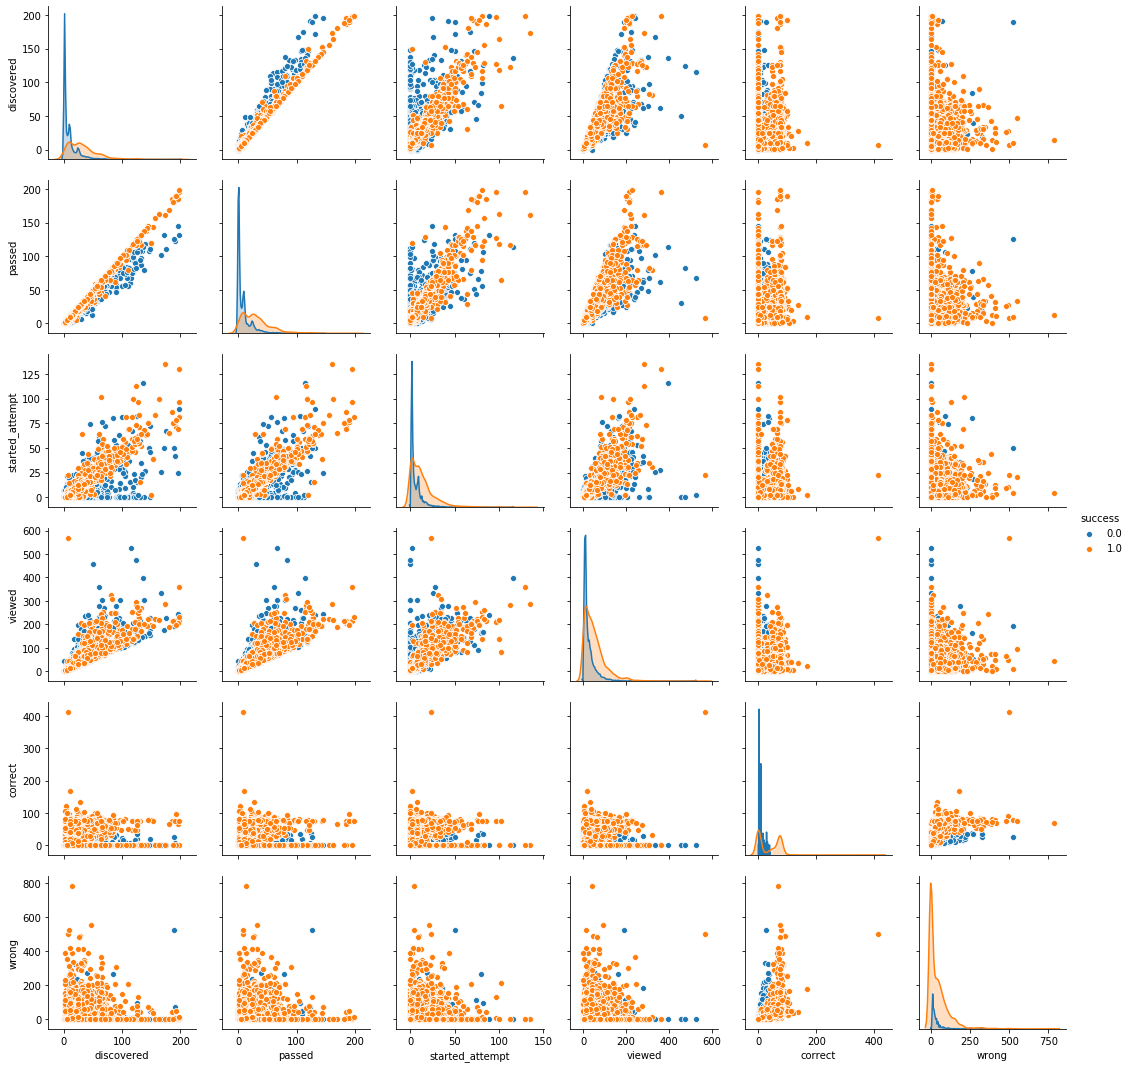

In [195]:
# Смотрим на зависимости пар переменных друг от друга
sns.pairplot(data=final_set, vars=final_set.columns[1:-1], hue='success')

In [154]:
# Выведим описательную статистику для всего сета
final_set.iloc[:,1:8].describe()

,discovered,passed,started_attempt,viewed,correct,wrong,success
count,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000
mean,12.364875,11.407040,4.109754,19.232973,5.897369,7.275658,0.104658
std,18.037964,16.814163,8.034247,32.075203,16.806590,28.022883,0.306121
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,6.000000,5.000000,1.000000,7.000000,0.000000,0.000000,0.000000
75%,16.000000,14.000000,5.000000,23.750000,1.000000,0.000000,0.000000
max,198.000000,198.000000,135.000000,568.000000,413.000000,785.000000,1.000000


Как видно из таблицы, больше 75 процетов пользователей не завершили курс успешно. Половина пользователей за первые 2 дня прошли только 5 степов и не сделали ни одного решения(правильного или нет).<br>
**Все переменные являются непрерывными и находятся приблизительно в одном масштабе**

<p style="font-family: Arial; font-size:2.75em;color:#2462C0; font-style:bold"><br>
Построение модели
</p>


In [196]:
#импортируем основные модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [200]:
# разбиваем сет на тренировочный и тестовый
train_X, test_X, train_y, test_y = train_test_split(final_set.iloc[:,1:-1],final_set['success'] , test_size=0.2,random_state=0)

In [204]:
#создаем классификатор
clf = RandomForestClassifier(random_state=0)
#определяем параметры дерева решения по которым будет происходить отбор
parametrs = {'n_estimators': range(1,8), 'max_depth': range(1, 6), 'min_samples_leaf': range(1,7), 
             'min_samples_split': range(2,11,2)}

In [206]:
#для подбора парметров дерева используем решетчатый поиск c кроссвалидацией равной 4
grid_search = GridSearchCV(clf,parametrs, cv=4, n_jobs=-1)

In [207]:
#фитим модель
grid_search.fit(train_X, train_y)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max

In [208]:
#посмотрим на оптимальные параметры
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 6}

In [209]:
# определяем лучшую модель
best_clf = grid_search.best_estimator_

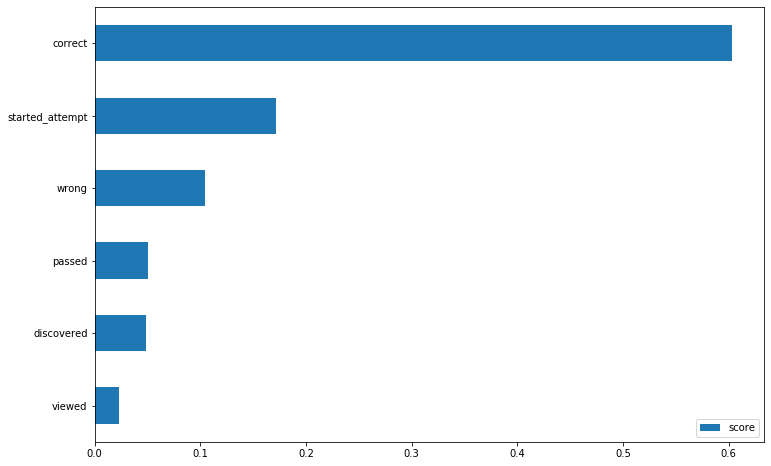

In [211]:
# посмотрим на распределение переменных которыми руководствовалось дерево
features = pd.DataFrame( best_clf.feature_importances_, index=train_X.columns, columns=['score'])
features.sort_values('score').plot(kind='barh', figsize=(12, 8))

<p style="font-family: Arial; font-size:2.75em;color:#2462C0; font-style:bold"><br>
Оценка модели
</p>

In [282]:
#посмотрим на на метрику accuracy
best_clf.score(test_X, test_y)

0.9508708084221471

Метрика точности показывает довольно высокий результат, однако при таком сильном дисбалансе классов в сторону отрицательного, этот
показатель может некорректно отражать обобщающую способность <br>
Поэтому посмотрим на Roc кривую

In [238]:
predict_prob = best_clf.predict_proba(test_X)

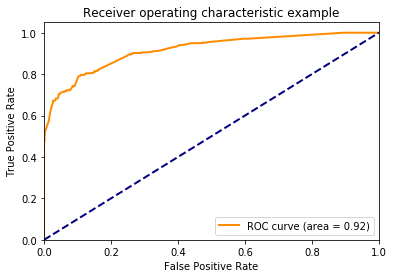

In [270]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_y, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Из графика видно, что в большинстве случаев модель правильно классифицирует положительные классы и редко неправильно классифицируем отрицательные.

In [284]:
final_set.to_csv("final_set.csv", index=False)